## Chapter 3: First order methods

# 3.5 Gradient Descent

In previous Sections we examined some fundamental characteristics of the tangent line / hyperplane defined by a function's first order Taylor series approximation.  In particular we saw how the negative gradient at a point provides a valid descent direction for a function itself, i.e., a direction that (at least locally) decreases the value of the function.  With this fact in hand it is then quite natural to ask the question: can we construct a local optimization method using the negative gradient at each step as our descent direction?  The answer is a resounding "yes", and the resulting scheme is precisely the *gradient descent algorithm* we aim to describe with this Chapter in full, and this Section in particular.    

In [17]:
## This code cell will not be shown in the HTML version of this notebook
# import standard tools
import sys
sys.path.append('../../')
import autograd.numpy as np
import time

# import custom plotting tools
from mlrefined_libraries import math_optimization_library as optlib
static_plotter = optlib.static_plotter.Visualizer();
anime_plotter = optlib.animation_plotter.Visualizer();

# The next three lines are needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

# center all images in notebook and associated html
from IPython.display import HTML
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
    width="400";
    height="400";
}
</style>
"""))

##  The gradient descent algorithm

As we introduced in the previous Chapter, a local optimization method is one where we aim to find minima of a given function by beginning at some point $\mathbf{w}^0$ and taking number of steps $\mathbf{w}^1, \mathbf{w}^2, \mathbf{w}^3,...,\mathbf{w}^{K}$ of the generic form 

\begin{equation}
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} + \alpha \mathbf{d}^{\,k}.
\end{equation}

where $\mathbf{d}^{\,k}$ are *descent direction* vectors (which ideally are *descent directions* that lead us to lower and lower parts of a function) and $\alpha$ is called the *steplength* parameter.  In Chapter 2 we saw in one simple example of a local method called random local search, which was fatally flawed due to the way it determines each *descent direction* $\mathbf{d}^{\,k}$ -i.e., via random search - which grows exponentially more inefficient as the dimension of a function's input increases.  (see [Section 2.5](https://jermwatt.github.io/machine_learning_refined/notes/2_Zero_order_methods/2_5_Random.html) for a complete introduction to this concept).

In our current setting - where we have just reviewed (in the previous Section) how the negative gradient $-\nabla g\left(\mathbf{w}\right)$ of a function $g\left(\mathbf{w}\right)$ computed at a particular point *always* defines a valid descent direction there - we are perfectly poised to think about another local method employing first order descent directions.  We could very naturally ask what a local method employing the negative gradient direction at each step might look like, and how it might behave - i.e., setting the descent direction $\mathbf{d}^{k} = -\nabla g\left(\mathbf{w}^{k-1}\right)$ in the above formula.  Such a sequence of steps would then take the form

\begin{equation}
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \nabla g\left(\mathbf{w}^{k-1}\right)
\end{equation}

and it seems intuitive - at least at the outset - that because each and every direction is guaranteed to be one of descent here that (provided we set $\alpha$ appropriately, as we must do whenever using a local optimization method)taking such steps could lead us to a point near the a local minimum of any function.  

Indeed this is precisely the *gradient descent algorithm*.  It is it called *gradient descent* - in employing the (negative) gradient as our descent direction - we are repeatedly *descending* in the *(negative) gradient direction* at each step.  

> The *gradient descent algorithm* is a local optimization method where - at each step - we employ the negative gradient as our descent direction.

Appreciate the power of this descent direction - which is almost literally given to us - over the zero-order methods detailed in the previous Chapter.  There we had to *search* to find a descent direction, here calculus provides us not only with a descent direction (without search), but an excellent one to boot. 

The path taken by gradient descent is illustrated figuratively below for a general single-input function.  At each step of this local optimization method we can think about drawing the first order Taylor series approximation to the function, and taking the descent direction of this tangent hyperplane (the negative gradient of the function at this point) as our descent direction for the algorithm.  Beginning at the point $w^0$ the point at which we make our first approximation is drawn below as a red dot, with the first order Taylor series approximation drawn in green.  Moving in the negative gradient descent direction provided by this approximation we arrive at a point $w^1 = w^0 - \alpha \frac{\partial}{\partial w}g\left(w^0\right)$ (remember - for a single input function the gradient is simply a single derivative), having taken our first gradient descent step.  We then repeat this process at $w^1$, moving in the negative gradient direction there, to $w^2 = w^1 - \alpha \frac{\partial}{\partial w}g\left(w^1\right)$, and so forth.

<figure>
<img src="../../mlrefined_images/math_optimization_images/Fig_2_7.png" width=700 height=250/>
  <figcaption>   
<strong>Figure 1:</strong> <em> A figurative drawing of the gradient descent algorithm.  The first order Taylor series approximation - and the *negative gradient* of the function in particular - provides an excellent and easily computed descent direction at each step of this local optimization method (here a number of Taylor series approximations are shown in green, and evaluations by the function and linear approximations are shown as red dots and crosses respectively).  Employing these directions at each step the *gradient descent algorithm* can be used to properly minimize generic functions.  Moreover, unlike the random local search algorithm, gradient descent scales very well with input dimension since the descent direction of a hyperplane is much more easily computed in high dimensions.
</em>  </figcaption> 
</figure>

As we will see here and throughout many of our future Chapters, the gradient descent algorithm is often a far better local optimization algorithm than the zero order approaches discussed in the previous Chapter (indeed it is probably the most popular optimization algorithm used in machine learning / deep learning today).  This is entirely due to the fact that the descent direction here - provided by calculus via the gradient - is universally easier to compute (particularly as the dimension of the input increases) than e.g., seeking out a descent direction at random.  In other words, the fact that the negative gradient direction - at least locally - provides a descent direction for the function itself combined with the fact that gradients are often cheap to compute makes gradient descent a superb local optimization method.

> The fact that the negative gradient direction - at least locally - provides a descent direction for the function itself combined with the fact that gradients are often cheap to compute makes gradient descent a superb local optimization method.


To this point we can very easily compute the gradient of almost any generic function of interest using a gradient calculator known as an Automatic Differentiator.  So in practice we need not even have to worry about computing the form of a function's gradient 'by hand'.

Below we provide the generic pseudo-code and ``Python`` implementation of the gradient descent algorithm which will be used in a variety of examples that follow in this Section.  We describe the most basic yet perhaps the most common implementation, but there are a number of practical variations one can use in practice - like e.g., different halting conditions other than a maximum number of steps, or what values are returned by the method - which we touch on below as well.

### The gradient descent algorithm

<hr style="height:1px;border:none;color:#555;background-color:#555;"/>
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> function $g$, steplength $\alpha$, maximum number of steps $K$, and initial point $\mathbf{w}^0$ <br/>

<strong>2:</strong>&nbsp;&nbsp; <code>for</code> $\,\,k = 1...K$<br/>

<strong>3:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;         $\mathbf{w}^k = \mathbf{w}^{k-1} - \alpha \nabla g\left(\mathbf{w}^{k-1}\right)$ <br/>

<strong>4:</strong>&nbsp; <strong>output:</strong> history of weights $\left\{\mathbf{w}^{k}\right\}_{k=0}^K$ and corresponding function evaluations $\left\{g\left(\mathbf{w}^{k}\right)\right\}_{k=0}^K$ <br/>

<hr style="height:1px;border:none;color:#555;background-color:#555;"/>
</p>

Note in particular the return values we have chosen to output in our pseudo-code above: 
both the entire sequence of gradient descent steps $\left\{\mathbf{w}^{k}\right\}_{k=0}^K$ and corresponding cost function evaluation $\left\{g\left(\mathbf{w}^{k}\right)\right\}_{k=0}^K$  computed while running the algorithm are returned.  Another common choice is more minimalist: simply return the final set of weights $\mathbf{w}^K$, or those providing the corresponding smallest cost function value during the run.  We return the entire sequence of weights and cost function evaluations by default because we use them as a *debugging tool for propertly setting the steplength / learning rate $\alpha$* via the *cost function history plot* (we show this in the examples below). 

How do we set the $\alpha$ parameter in general?  With gradient descent there are a wide variety of paradigmns for choosing the steplength, but the basic (and most commonly used) choices are precisely those we introduced in the (comparatively simpler) context of zero order methods in Section 2.3: that is fixed and diminishing steplegnth choices.  We explore this idea further in a subsection below.

>> The most common choice of steplength / learning rate for use with gradient descent are precisely those introduced in the (comparatively simpler) context of zero order methods (see e.g., 2.3): fixed and diminishing steplength rules.

When does gradient descent stop?  Technically - if the steplength is chosen wisely - the algorithm will *halt near stationary points of a function, typically minima or saddle points*.  How do we know this?  By the very form of the gradient descent step itself.  If the step

\begin{equation}
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \nabla g\left(\mathbf{w}^{k-1}\right)
\end{equation}

does not move from the prior point $\mathbf{w}^{\,k-1}$ significantly then this can mean only one thing: *that the direction we are traveling in is vanishing* i.e., $-\nabla g\left(\mathbf{w}^k\right) \approx \mathbf{0}_{N\times 1}$.  This is - by definition - a *stationary point* of the function.

>> Gradient descent naturally halts near stationary points of a function, commonly near minima or saddle points, since these are where the descent direction vanishes i.e., where $-\nabla g\left(\mathbf{w}^k\right) \approx \mathbf{0}_{N\times 1}$. 

##  A generic ``Python`` implementation of the gradient descent algorithm

In the next ``Python`` cell we implement gradient descent as described above.  It involves just a few requisite initializations, the computation of the gradient function via e.g., an Automatic Differentiator, and the very simple ``for`` loop.  The output is a history of the weights and corresponding cost function values at each step of the gradient descent algorithm.

It is especially important to recognize that when employing an Automatic Differentiator to compute each gradient evaluation - as we do here (we use [autograd](https://github.com/HIPS/autograd)) - that we get each of these function evaluations 'for free' when computing the corresponding gradient evaluation.  So - in terms of evaluating the function itself - we only need to do this ourselves at the final step (since we do not compute the gradient there).

In [2]:
# import automatic differentiator to compute gradient module
from autograd import grad 

# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def gradient_descent(g,alpha,max_its,w):
    # compute gradient module using autograd
    gradient = grad(g)

    # run the gradient descent loop
    weight_history = [w]           # container for weight history
    cost_history = [g(w)]          # container for corresponding cost function history
    for k in range(max_its):
        # evaluate the gradient, store current weights and cost function value
        grad_eval = gradient(w)

        # take gradient descent step
        w = w - alpha*grad_eval
        
        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(w))
    return weight_history,cost_history

Given the input to $g$ is $N$ dimensional a general random initialization - the kind that is often used - can be written as shown below.  Here the function `random.randn` produces samples from a standard Normal distribution with mean zero and unit standard deviation.  It is also common to scale such initializations by small constants like e.g., $0.1$. 

In [3]:
# a common initialization scheme - a random point
N = 10
w = np.random.randn(N,1)

 #### <span style="color:#a50e3e;">Example 1. </span>  A convex single input example 

Here we use gradient descent to minimize the polynomial function

\begin{equation}
g(w) = \frac{1}{50}\left(w^4 + w^2 + 10w\right).
\end{equation}

In Section 3.2 on the *first order optimality condition*  we saw that the global minimum of this problem - which we could not compute by hand easily - was given explicitly as  

\begin{equation}
w = \frac{\sqrt[\leftroot{-2}\uproot{2}3]{\sqrt[\leftroot{-2}\uproot{2}]{2031} - 45}}{6^{\frac{2}{3}}} - \frac{1}{\sqrt[\leftroot{-2}\uproot{2}3]{6\left(\sqrt{2031}-45\right)}}
\end{equation}

With gradient descent we can easily determine a point that is arbitrarily close to this one.  This illustrates the general principle that gradient descent - and local search in general - can compute minima of functions that we cannot compute by hand using calculus alone.

Note however that while computing this minimum by hand is difficult, computing the gradient (for use in the gradient descent algorithm) is quite simple.  It is easy to check that the gradient of the function above is given as 

\begin{equation}
\frac{\partial}{\partial w}g\left(w\right) = \frac{2}{25}w^3 + \frac{1}{25}w + \frac{1}{5}. 
\end{equation}


Alternatively we can also use an Automatic Differentiator to compute this derivative.

Below we animate the process of gradient descent applied to minimize this function.  We initialize the algorithm at $w^0 = 2.5$, set the steplength constant for all steps as $\alpha = 1$, and run for 25 iterations.  As you move the slider left to right the descent process as described above is shown visually - including the illustration of the tangent line.  We mark the evaluation of each step of the process on both the function and the tangent line for visualization purposes.  Moving the slider all the way to the right we can see that the algorithm begins to slow down considerably near the global minimum of the function.

In [4]:
# This code cell will not be shown in the HTML version of this notebook
# what function should we play with?  Defined in the next line.
g = lambda w: 1/float(50)*(w**4 + w**2 + 10*w)   # try other functions too!  Like g = lambda w: np.cos(2*w) , g = lambda w: np.sin(5*w) + 0.1*w**2, g = lambda w: np.cos(5*w)*np.sin(w)

# run gradient descent 
w = 2.5; alpha = 1; max_its = 25;
weight_history,cost_history = gradient_descent(g,alpha,max_its,w)

# animate gradient descent applied to minimizing this function
anime_plotter.gradient_descent(g,weight_history,savepath='videos/animation_6.mp4',fps=1)

In [5]:
# load video into notebook
from IPython.display import HTML
HTML("""
<video width="1000" height="400" controls loop>
  <source src="videos/animation_6.mp4" type="video/mp4">
  </video>
""")

#### <span style="color:#a50e3e;">Example 2. </span> A non-convex single input example

In theory for *the most general non-convex functions*, in order to find the global minimum of a function using gradient descent one may need to run it several times with different initializations and/or steplength schemes - as is true when applying any local optimization method.  Using the function

\begin{equation}
g(w) = \text{sin}(3w) + 0.1w^2
\end{equation}

which is illustrated alone in the left panel below, we initialize two runs - at $w^0 = 4.5$ and $w^0 = -1.5$.  For both runs we use a steplength of $\alpha = 0.05$ fixed for all 10 iterations.  As can be seen by the result (right panel) depending on where we initialize we may end up near a local or global minimum - here resulting from the first and second initialization respectively.  Here we illustrate the steps of each run as circles along the input axis with corresponding evaluations on the function itself as a similarly colored 'x'.  The steps of each run are colored green near the start of the run to red when a run halts.  

<IPython.core.display.Javascript object>


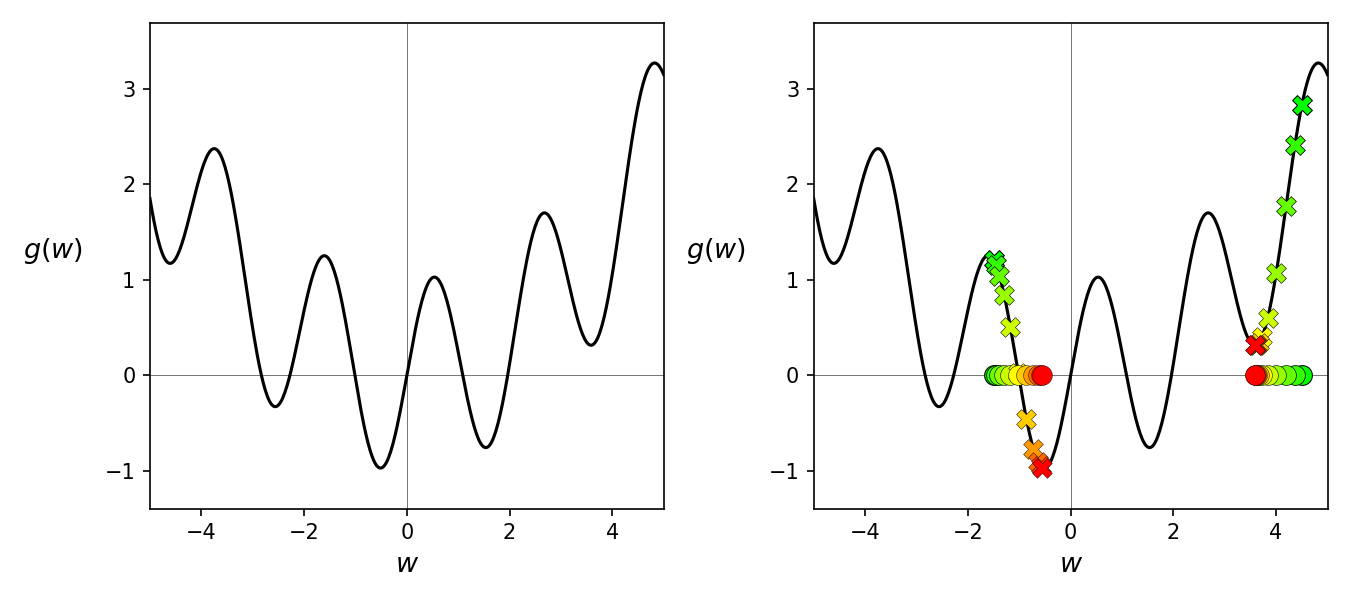

In [6]:
# This code cell will not be shown in the HTML version of this notebook
# what function should we play with?  Defined in the next line.
g = lambda w: np.sin(3*w) + 0.1*w**2

# run gradient descent
alpha = 0.05; w = 4.5; max_its = 10;
weight_history_1,cost_history_1 = gradient_descent(g,alpha,max_its,w)

alpha = 0.05; w = -1.5; max_its = 10;
weight_history_2,cost_history_2 = gradient_descent(g,alpha,max_its,w)

# make static plot showcasing each step of this run
static_plotter.single_input_plot(g,[weight_history_1,weight_history_2],[cost_history_1,cost_history_2],wmin = -5,wmax = 5)

We can plot both runs using the *cost function history plot* which allows us to view the progress of gradient descent (or any local optimization method - see Section 5.4 where they are first introduced) runs regardless of the input dimension of the function we are minimizing.  

<IPython.core.display.Javascript object>


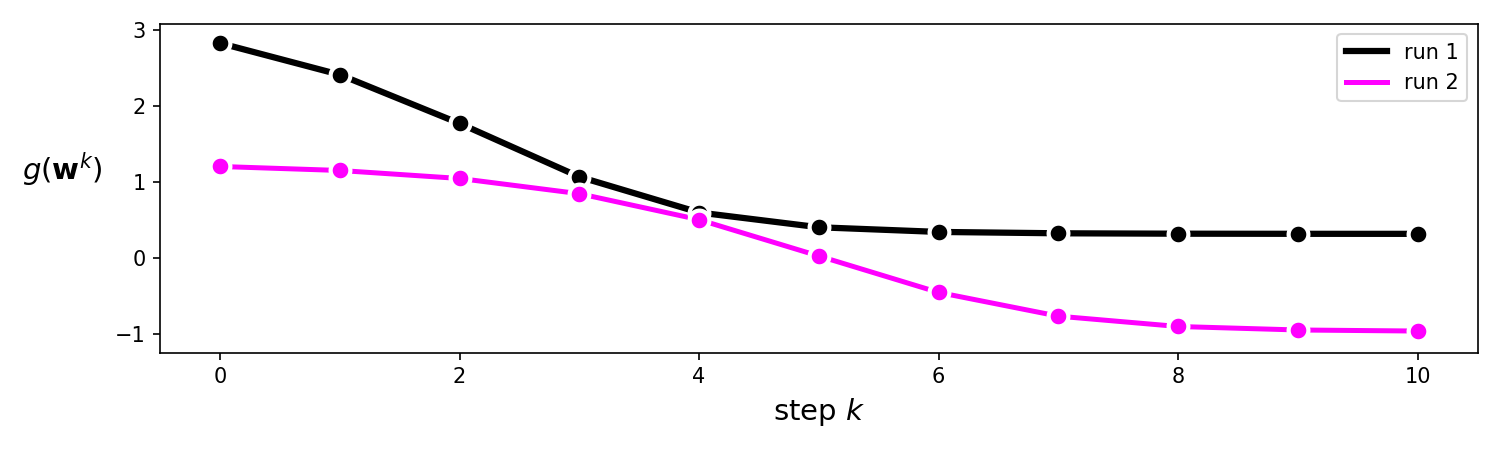

In [7]:
# This code cell will not be shown in the HTML version of this notebook
# plot the cost function history for a given run
static_plotter.plot_cost_histories([cost_history_1,cost_history_2],start = 0,points = True,labels = ['run 1','run 2'])

These cost function history plots are a valuable debugging tool, as well as a valuable tool for selecting proper values for the steplength $\alpha$.  This is particularly true with higher dimensional functions (that we cannot visualize) - which are the most common kind we will encounter in machine learning.

> Cost function history plots are a valuable debugging tool, as well as a valuable tool for selecting proper values for the steplength $\alpha$.  This is particularly true with higher dimensional functions (that we cannot visualize) - which are the most common kind we will encounter in machine learning.

 #### <span style="color:#a50e3e;">Example 3. </span>  A convex multi-input example 

Next we run gradient descent on the multi-input quadratic function $g(w_1,w_2) = w_1^2 + w_2^2 + 2$.  We take 10 steps each using the steplength / learning rate value $\alpha = 0.1$.  We can employ gradient descent by using the hand-computed gradient of this funciton, which one can easily compute is as follows

\begin{equation}
\nabla g \left(\mathbf{w}\right) = 
\begin{bmatrix}
2w_1 \\
2w_2
\end{bmatrix}
\end{equation}

or by using an Automatic Differentiator. 


We illustrate the path taken by this run of gradient descent in the input space of the function, coloring the steps from red (near the start of the run) to green as the method finishes.  This is shown along with the three-dimensional surface of the function in the left panel, and 'from above' showing the contours of the function on its input space in the right panel.  Once again we halt near a stationary point, here the global minimum of the function. 

<IPython.core.display.Javascript object>


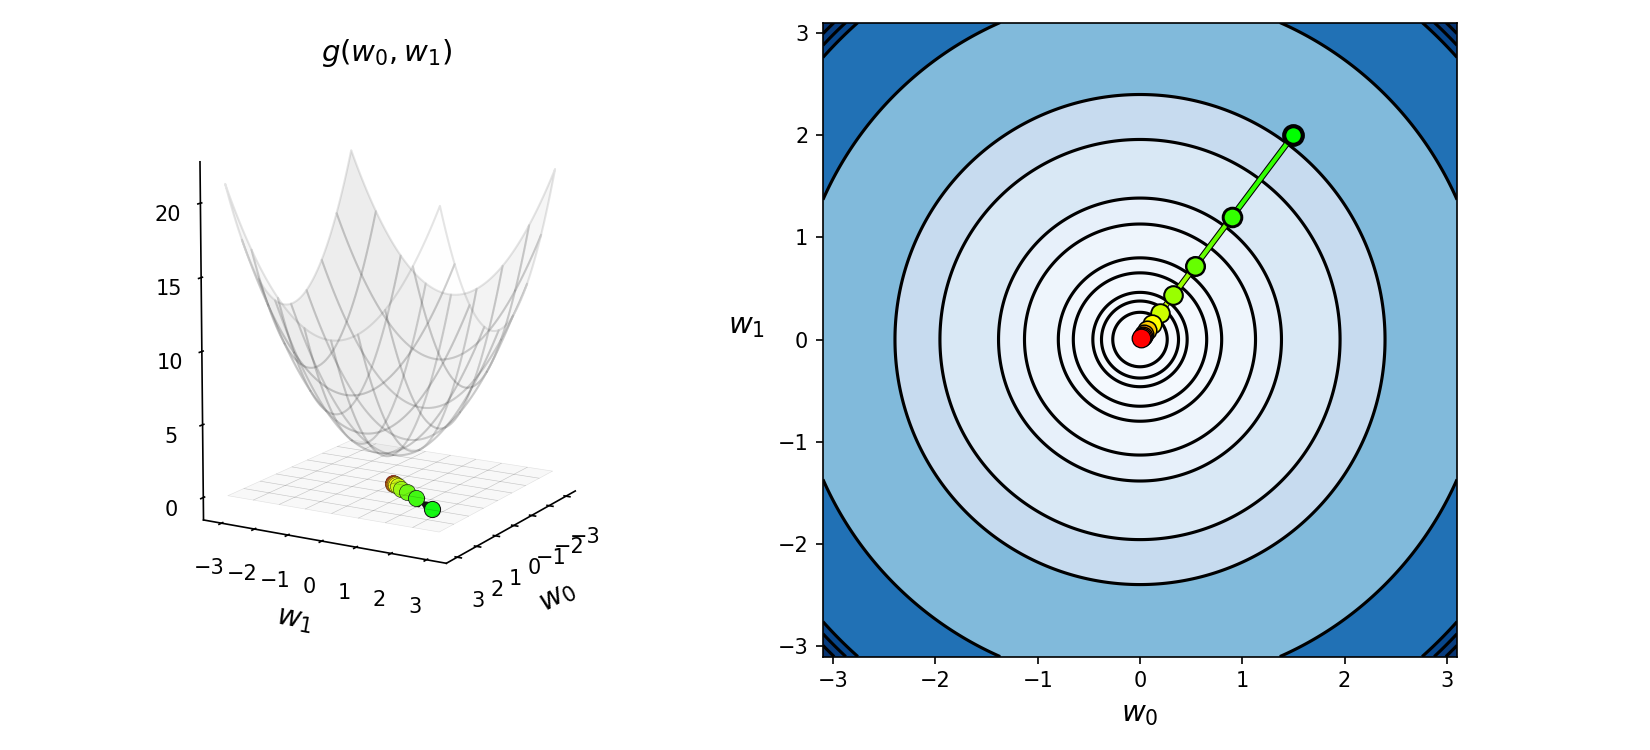

In [8]:
# This code cell will not be shown in the HTML version of this notebook
# what function should we play with?  Defined in the next line.
g = lambda w: np.dot(w.T,w) + 2

# run gradient descent 
w = np.array([1.5,2]); max_its = 10; alpha = 0.2;
weight_history,cost_history = gradient_descent(g,alpha,max_its,w)

# show run in both three-dimensions and just the input space via the contour plot
static_plotter.two_input_surface_contour_plot(g,weight_history,num_contours = 25,view = [10,30])

We can visualize this - as well as any other run of a local optimization method - by using the *cost function history plot* (see Section 5.4 where this visualization was first introduced).  In short, this allows us to view the progress of this run (for parameter tuning and debugging purposes) regardless of the dimension of the function we are minimizing.

<IPython.core.display.Javascript object>


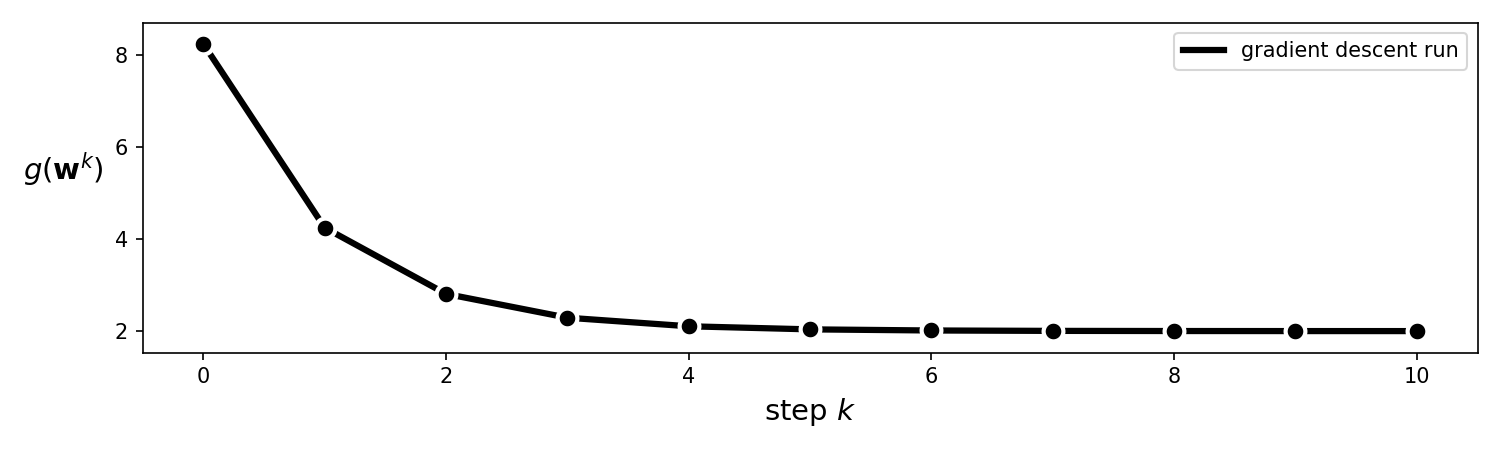

In [9]:
# This code cell will not be shown in the HTML version of this notebook
# plot the cost function history for a given run
static_plotter.plot_cost_histories([cost_history],start = 0,points = True,labels = ['gradient descent run'])

##  Basic steplength choices for gradient descent

Just like all local methods, one needs to carefully choose the steplength / learning rate parameter $\alpha$.  While there are an array of available sophisticated methods for choosing $\alpha$ in the case of gradient descent, the most common choices employed in machine learning are those basic approaches first detailed in the simple context of zero order methods in Section 2.3.  That is the most common choices are 

- using a fixed $\alpha$ value for each step of a gradient descent run, which for simplicity's sake commonly takes the form of $10^{-\gamma}$ where $\gamma$ is an integer, or 


- using a diminishing rate like $\alpha = \frac{1}{k}$ where at the $k^{th}$ step of a run.  


In both instances our aim in choosing a particular value for the steplength / learning rate $\alpha$ at each step of gradient descent mirrors that of any other local optimization method: $\alpha$ should be chosen to induce the most rapid minimization possible.  With the fixed steplength this often means choosing the *largest* possible value for $\alpha$ that leads to proper convergence.

> Choosing a particular value for the steplength / learning rate $\alpha$ at each step of gradient descent mirrors that of any other local optimization method: $\alpha$ should be chosen to induce the most rapid minimization possible. 

Below we discuss a number of examples employing these two common choices of $\alpha$, and (for the sake of completion) detail some more advanced methods for steplength selection in Section 3.9.

#### <span style="color:#a50e3e;">Example 4. </span>  An example of fixed steplength selection for a single input convex function

At each step of gradient descent we *always* have a descent direction - this is defined explicitly by the negative gradient itself, we need not have to search one out as with the random local search method (which becomes almost impossible to do in higher input dimensions).  This is a huge plus.  However whether or not we descend in the function when taking this step depends completely on how far along it we travel, or in other words our choice of the steplength parameter.  This is not to say that the general steplength rules we have seen so far - i.e., fixing the steplength to a hand-tuned constant for all steps or using a diminishing steplength like $\alpha = \frac{1}{k}$ - are not perfectly applicable for use with gradient descent - they absolutely are.  Indeed these are the most popular choices for setting the steplength parameter in machine learning / deep learning.  Nonetheless there are even more more mathematically sound but often more expensive choices for the selecting steplengths for gradient descent we will in the next Section.  But it is important to keep in mind the fact that just because we move in a descent *direction* with gradient descent does not mean that we always descend in the function itself when using a fixed or diminishing steplength rule.

We illustrate this general principle in the next Python cell using a slider widget to animate what the first 5 steps of (unnormalized) gradient descent look like applied to the simple quadratic function $g(w) = w^2$.  Here we initialize at $w^0 = -2.5$ using a fixed steplength parameter rule.  We show the function evaluation at each step of the algorithm (not the step itself, which is in the input space), and color them from green at the start of the run to red when the last step is taken.  As you move the slider from left to right each frame shows a different run with a slightly increased fixed steplength value  $\alpha$ used for all steps, whose numerical value is printed above the left panel.  In the beginning the steplength is extremely small - so small that we do not descend very much at all.  On the other end of the spectrum however, when we set 

In the right panel we show what a *cost function plot* that simply plots the evaluation of $g$ at each step of gradient descent run sequentially in order from the evaluation of the initial point $g\left(w^0\right)$ on the left, to the final step evaluation $g\left(w^5\right)$.  We also color these points from green (start of run) to red (end of run).  The cost function plot is a very useful tool in general - particularly for multi-input functions that take in $N > 2$ inputs (so most machine learning / deep learning problems) which we cannot directly visualize - for understanding the behavior any local search method like gradient descent. 

In [10]:
# This code cell will not be shown in the HTML version of this notebook
# what function should we play with?  Defined in the next line., nice setting here is g = cos(2*w), w_init = 0.4, alpha_range = np.linspace(2*10**-4,1,200)
g = lambda w: w**2

# create an instance of the visualizer with this function
demo = optlib.grad_descent_steplength_adjuster_2d.visualizer()

# run the visualizer for our chosen input function, initial point, and step length alpha
w_init = -2.5
steplength_range = np.linspace(10**-5,1.5,150)
max_its = 5
demo.animate_it(savepath='videos/animation_7.mp4',w_init = w_init, g = g, steplength_range = steplength_range,max_its = max_its,tracers = 'on',version = 'unnormalized',fps=10)

In [11]:
# load video into notebook
from IPython.display import HTML
HTML("""
<video width="1000" height="400" controls loop>
  <source src="videos/animation_7.mp4" type="video/mp4">
  </video>
""")

When the steplength parameter is set too large, and the sequence of evaluations begins to rocket out of control, the sequence of steps is said to *diverge*.  This sort of example suggests that it is good practice when implementing gradient descent (employing  hand-tuned fixed steplength or diminishing steplength rule) one should usually, at each step, make sure to also keep track of the best weights seen thus far in the process (i.e., those providing the lowest function value).  This is because the final weights resulting from the run may not in fact provide the lowest value depending on function / steplength parameter setting / etc.,

#### <span style="color:#a50e3e;">Example 5. </span>  An example of fixed steplength selection for a multi-input non-convex function

We illustrate this same concept for a function taking in two inputs - here the simple sinusoid $g\left(w_1,w_2\right) = \text{sin}(w_1)$

In [12]:
# This code cell will not be shown in the HTML version of this notebook
# what function should we play with?  Defined in the next line., nice setting here is g = cos(2*w), w_init = 0.4, alpha_range = np.linspace(2*10**-4,1,200)
g = lambda w: np.sin(w[0])

# create an instance of the visualizer with this function
demo = optlib.grad_descent_steplength_adjuster_3d.visualizer()

# run the visualizer for our chosen input function, initial point, and step length alpha
w_init = [1,0]; alpha_range = np.linspace(2*10**-4,5,200); max_its = 10; view = [10,120];
demo.animate_it(savepath='videos/animation_8.mp4',g = g,w_init = w_init,alpha_range = alpha_range,max_its = max_its,view = view,fps=10)

In [13]:
# load video into notebook
from IPython.display import HTML
HTML("""
<video width="1000" height="400" controls loop>
  <source src="videos/animation_8.mp4" type="video/mp4">
  </video>
""")

#### <span style="color:#a50e3e;">Example 6. </span>  Comparing fixed and diminishing steplengths for a single input convex function

Below we illustrate the comparison of a fixed steplength scheme and a the diminishing steplength rule to minimize the function

\begin{equation}
g(w) = \left \vert w \right \vert.
\end{equation}

Notice that this function has a single global minimum at $w = 0$ and a derivative defined (everywhere but at $w = 0$)

\begin{equation}
\frac{\mathrm{d}}{\mathrm{d}w}g(w) = \begin{cases}
+1 \,\,\,\,\,\text{if} \,\, w > 0 \\
-1 \,\,\,\,\,\text{if} \,\, w < 0.
\end{cases}
\end{equation}

which makes the use of any fixed steplength scheme problematic for gradient descent.  Below we make two runs of $20$ steps of gradient descent each initialized at the point $w^0 = 2$, the first with a fixed steplength rule of $\alpha = 0.5$ (left panel) for each and every step, and the second using the diminishing steplength rule $\alpha = \frac{1}{k}$ (right panel).

<IPython.core.display.Javascript object>


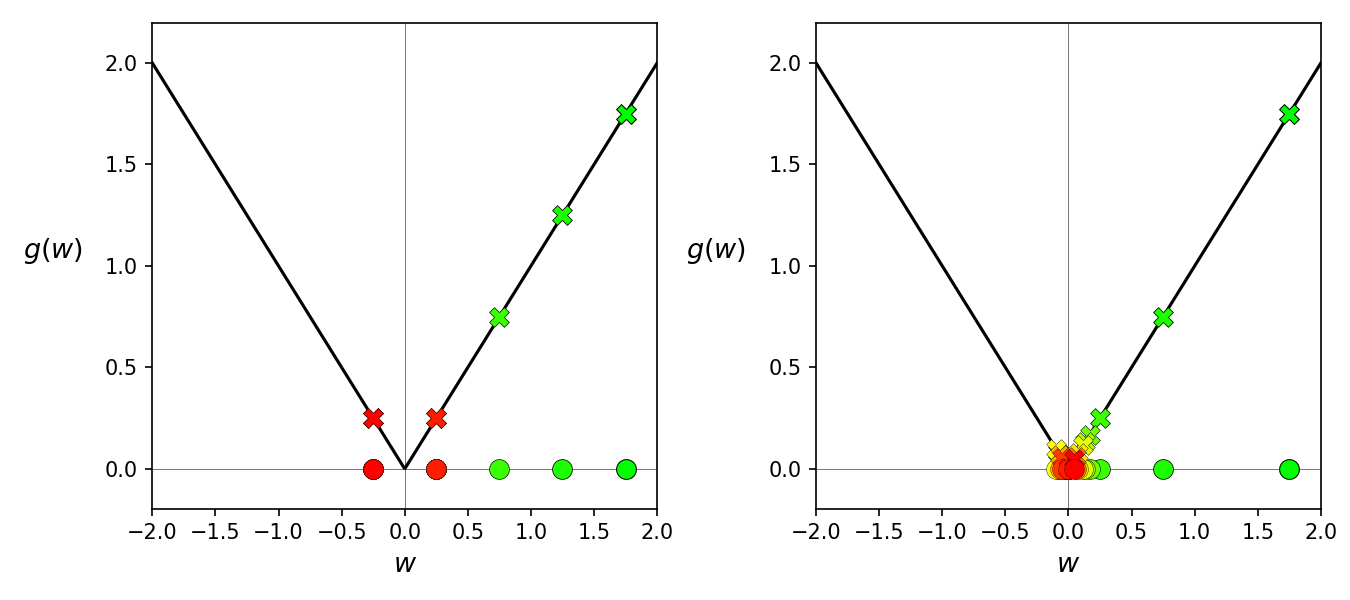

In [20]:
# This code cell will not be shown in the HTML version of this notebook
# what function should we play with?  Defined in the next line.
g = lambda w: np.abs(w)

# run gradient descent
alpha_choice = 0.5; w = 1.75; max_its = 20;
weight_history_1,cost_history_1 = gradient_descent(g,alpha_choice,max_its,w)

alpha_choice = 'diminishing'; w = 1.75; max_its = 20;
weight_history_2,cost_history_2 =  optlib.optimizers.gradient_descent(g,alpha_choice,max_its,w)

# make static plot showcasing each step of this run
static_plotter.single_input_plot(g,[weight_history_1,weight_history_2],[cost_history_1,cost_history_2],wmin = -2,wmax = 2,onerun_perplot = True)

We can see that indeed here a diminishing steplength is absolutely necessary in order to reach a point close to the minimum of this function.  We can see this even more clearly via the cost function history plot below.

<IPython.core.display.Javascript object>


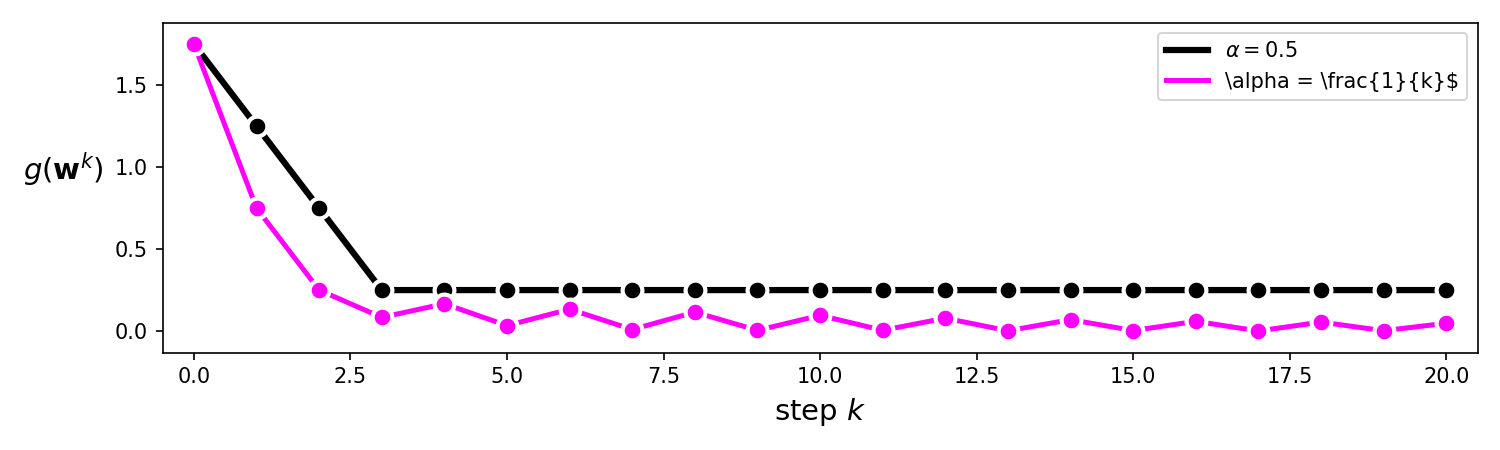

In [21]:
# This code cell will not be shown in the HTML version of this notebook
# plot the cost function history for a given run
static_plotter.plot_cost_histories([cost_history_1,cost_history_2],start = 0,points = True,labels = [r'$\alpha = 0.5$',r'\alpha = \frac{1}{k}$'])

## Oscillation in the cost function history plot is not *always* a bad thing

Remember that in practice in machine learning - since we regularly deal with cost functions that take in far too many inputs / are far to high dimensional to visualize - we use the *cost function history plot* to tune our steplength parameter $\alpha$, as well as debug an implementation of the algorithm.  

Note that when employing the cost function plot in choosing a proper steplength value it is not ultimately important that the plot associated to a run of gradient descent (or any local method) be *strictly decreasing* (that is showing that the algorithm *descended* at every single step).  It is critical to find a value of $\alpha$ that allows gradient descent find the lowest value possible - which may mean that not every step *descends*.  In other words, the *best* choice of $\alpha$ for a given minimization might cause gradient descent to 'hop around' some, moving up and down, and not the one that shows descent in each and every step.  Below we show an example illustrating this point.

#### <span style="color:#a50e3e;">Example 6. </span>  A simple example illustrating how choosing an value of  $\alpha$ might be one that causes a function history plot to 'hop around' 

In the example below we show the result of three runs of gradient descent to minimize the function

\begin{equation}
g\left(\mathbf{w}\right) = w_0^2 + w_1^2 + 2\,\text{sin}\left(1.5\left(w_0 + w_1\right)\right)^2 + 2
\end{equation}

whose contour plot is shown below.  You can see a *local minimum* around the point $\begin{bmatrix} 1.5 \\ 1.5 \end{bmatrix}$, and a global minimum near $\begin{bmatrix} -0.5 \\ -0.5 \end{bmatrix}$.  All three runs start at the same initial point $\mathbf{w}^{0} = \begin{bmatrix} 3 \\ 3 \end{bmatrix}$ and take $10$ steps, and all three runs use a (different) fixed steplength.  the first run uses a fixed steplength of $\alpha = 10^{-2}$, the second run $\alpha = 10^{-1}$, and the third run $\alpha = 10^{0}$. 

<IPython.core.display.Javascript object>


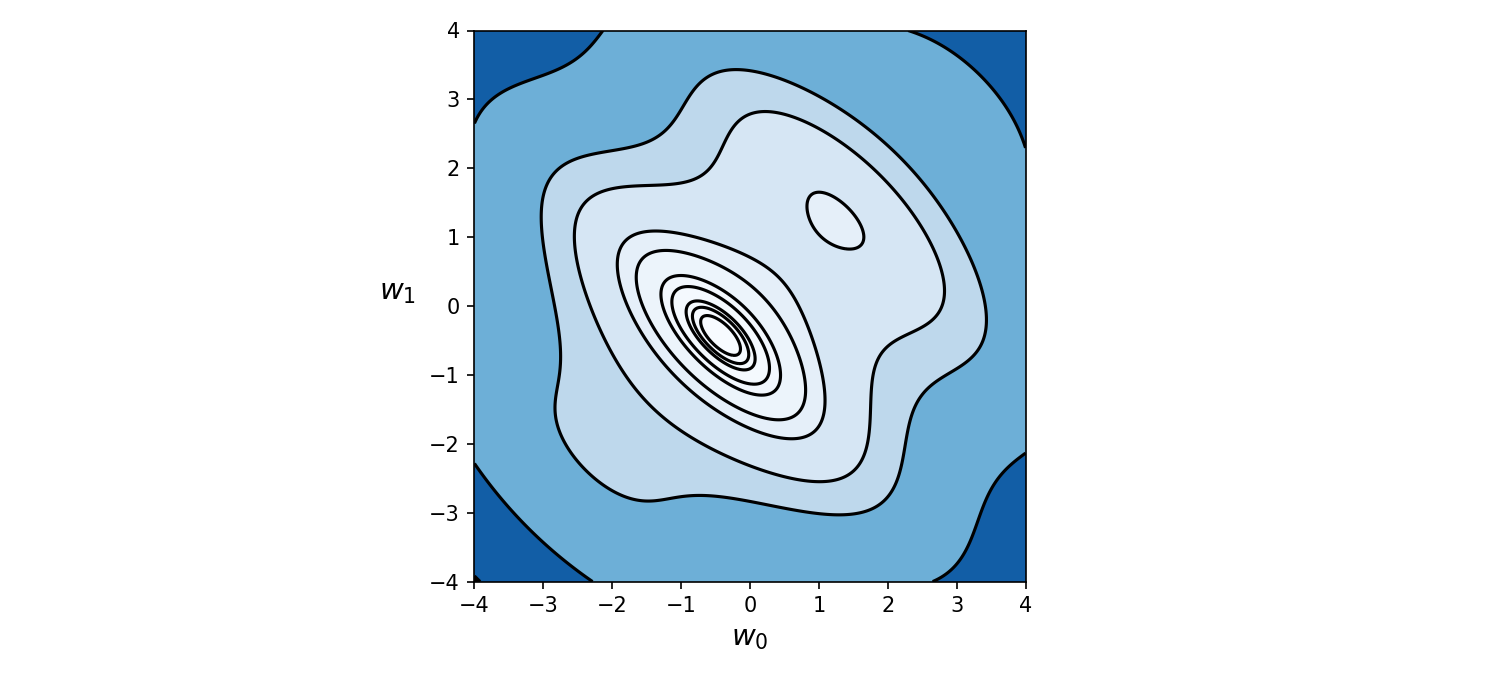

In [22]:
# This code cell will not be shown in the HTML version of this notebook
# what function should we play with?  Defined in the next line.
g = lambda w: w[0]**2 + w[1]**2 + 2*np.sin(1.5*(w[0] + w[1])) + 2

# first run
w = np.array([3.0,3.0]); max_its = 10; 
alpha_choice = 10**(-2);
weight_history_1,cost_history_1 = gradient_descent(g,alpha_choice,max_its,w)

# second run
alpha_choice = 10**(-1);
weight_history_2,cost_history_2 = gradient_descent(g,alpha_choice,max_its,w)

# third run
alpha_choice = 10**(0);
weight_history_3,cost_history_3 = gradient_descent(g,alpha_choice,max_its,w)

# plot contours
static_plotter.two_input_original_contour_plot(g,num_contours = 25,xmin = -4,xmax = 4, ymin = -4, ymax = 4)

Below we plot the cost function history plot associated with each run of gradient descent, showing the first, second, and third run in black, pink, and blue respectively.  We can see that the final run (in green), while 'hopping around' and not strictly decreasing at each step, finds the lowest point e.g., on its first step!  So while this run used the largest steplegnth $\alpha = 10^{0}$, clearly leading to oscillatory (and perhaps - eventually - divergent behavior) - it does indeed find the lowest point out of all three runs performed.

<IPython.core.display.Javascript object>


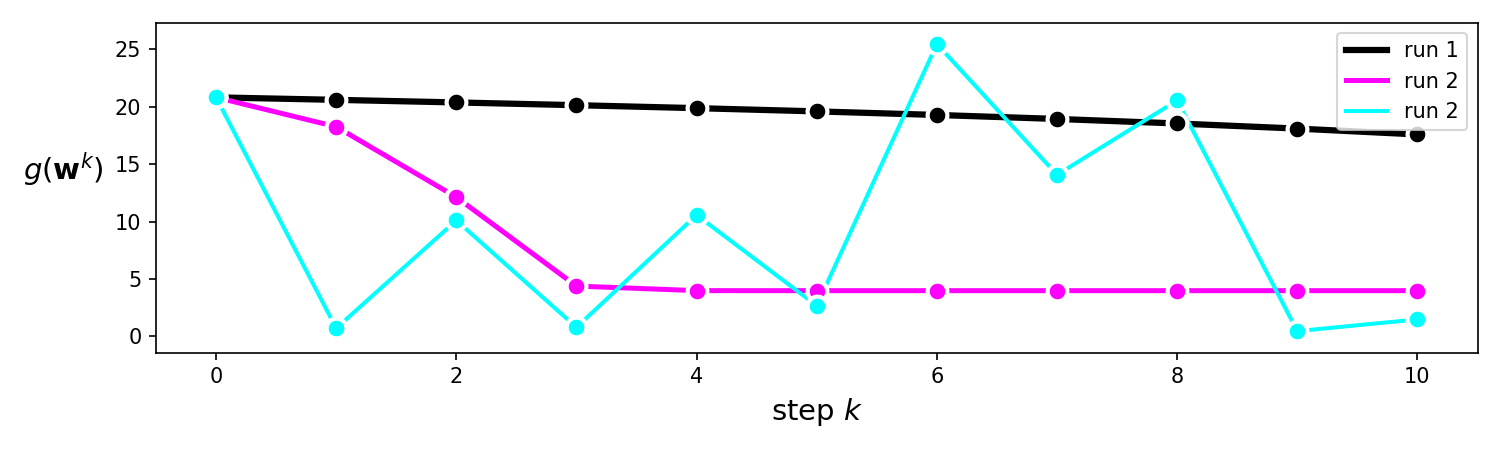

In [23]:
# This code cell will not be shown in the HTML version of this notebook
# plot the cost function history for a given run
static_plotter.plot_cost_histories([cost_history_1,cost_history_2,cost_history_3],start = 0,points = True,labels = ['run 1','run 2'])

Since this function takes in two inputs we can actually plot the weight history of each gradient descent run on the contour plot itself, and analyze exactly what happened in each case.  In the left, middle, and right panels below we do this plotting the resulting weight history of the first, second, and third run respectively.  In each case we color the steps green (at the start of each run) to red (at the conclusion of each run) and draw arrows pointing from one stsep to the next.  We also color the *edge* of every step of a run using the same color used above (i.e., black for the first run, pink for the second, and blue for the third).

In the left plot we can see that the first run does not make significant progress at all - meaning that for this particular example the steplength $\alpha = 10^{-2}$ was too small.  In the center panel - where our second run is visualized - we can see that the algorithm results in descent at each step, but converges to the *local minimum* located near  $\begin{bmatrix} 1.5 \\ 1.5 \end{bmatrix}$.  The third run using the largest steplength - visualized in the right panel - oscillates wildly across the function, but reaches a point near the *global minimum* near $\begin{bmatrix} -0.5 \\ -0.5 \end{bmatrix}$ several times (including at the first step).  

<IPython.core.display.Javascript object>


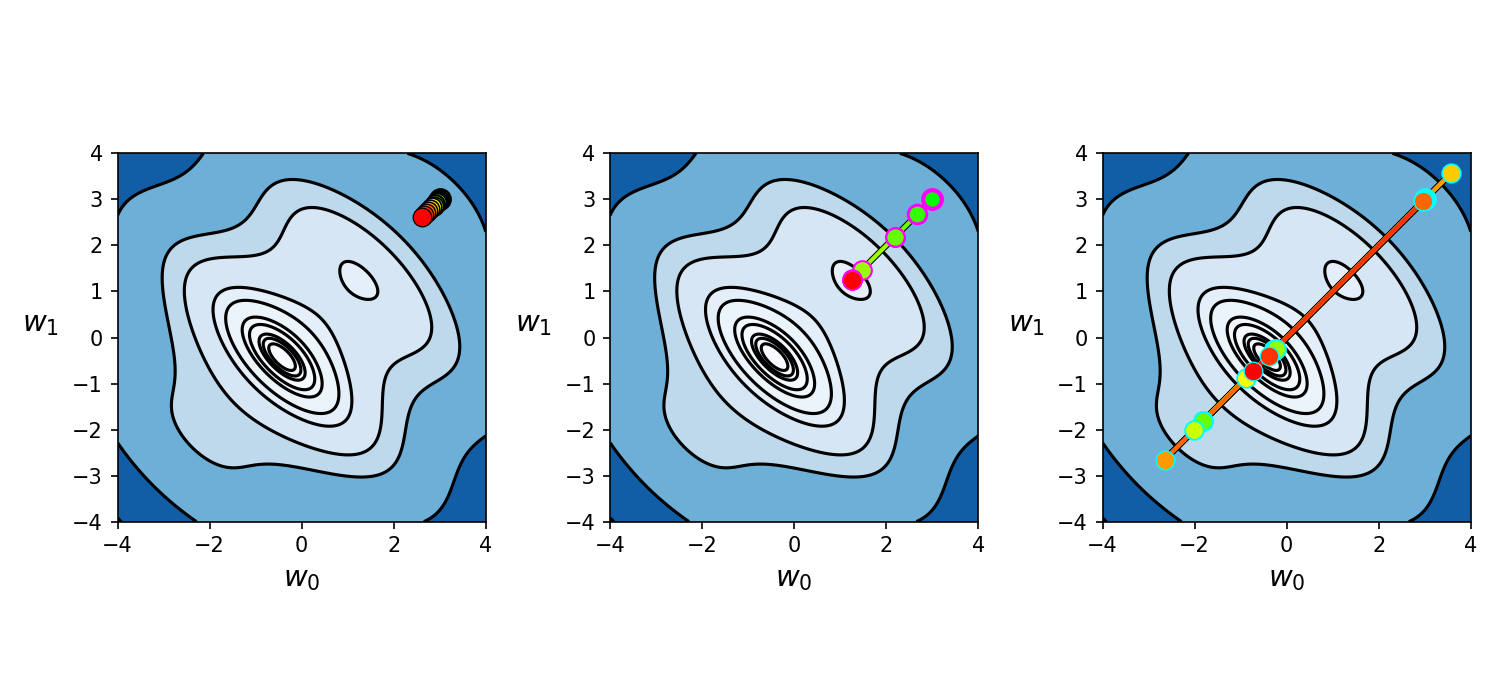

In [24]:
# This code cell will not be shown in the HTML version of this notebook
# show run in both three-dimensions and just the input space via the contour plot
histories = [weight_history_1,weight_history_2,weight_history_3]
static_plotter.two_input_contour_horiz_plots(g,histories,show_original=False,num_contours=25,xmin=-4,xmax=4,ymin=-4,ymax=4)

##   Convergence behavior and steplength parameter selection


When does gradient descent stop?  Technically - if the steplength is chosen wisely - the algorithm will \emph{halt near stationary points of a function, typically minima or saddle points}. How do we know this?  By the very form of the gradient descent step itself.  If the step $\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \nabla g\left(\mathbf{w}^{k-1}\right)$ does not move from the prior point $\mathbf{w}^{\,k-1}$ significantly then this can mean only one thing: \emph{that the direction we are traveling in is vanishing} i.e., $-\nabla g\left(\mathbf{w}^k\right) \approx \mathbf{0}_{N\times 1}$.  This is - by definition - a \emph{stationary point} of the function.

In principle then we can wait for gradient descent to get sufficiently close to a stationary point by ensure e.g., that the magnitude of the gradient $\left\Vert \nabla g\left(\mathbf{w}^{\,k-1}\right)\right\Vert_2$ is sufficiently small.  However in practice, as with most local optimization schemes, the most practical way to halt gradient descent is to simply run the algorithm for a fixed number of maximum iterations. 

What is good number for a maximum iteration count?  As with any local method this is typically set manually / heuristically, and is influenced by things like computing resources, knowledge of the particular function being minimized, and - very importantly - the choice of the steplength parameter \(\alpha\).   Smaller choices for \(\alpha\) - while more easily providing descent at each step - frequently require more for the algorithm to achieve significant progress.  Conversely if \(\alpha\) is set too large gradient descent may bounce around erratically forever never localizing in an adequate solution.